# タイタニック号の生存者をデータから予測する

In [47]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
#%pylab

In [2]:
titanic_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df.info()
print("-------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare   

In [4]:
# 予測に関係ないと思われる， 登場者ID, 名前，　チケット（購入場所，会社等）を　データから落とす

titanic_df = titanic_df.drop(["PassengerId","Name","Ticket"], axis=1)
test_df     = test_df.drop(['PassengerId','Name','Ticket'], axis=1)

In [5]:
titanic_df['Cabin'].isnull().sum()

687

In [6]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [7]:
titanic_df.shape

(891, 9)

In [8]:
Emb_dict = {key:val for val, key in enumerate(np.unique(titanic_df.dropna()["Embarked"]))}

df_emb = titanic_df['Embarked'].map(Emb_dict)

inv_Emb_dict = {val:key for key, val in Emb_dict.items()}


In [9]:
y = df_emb==2
y.sum()

inv_Emb_dict[2]

'S'

## Embarked と生存率の関係をプロットして検証

In [10]:
# Embarked の値ごとに Surivived を計算して割合をプロット
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5)) #３つのサブプロット用のfig領域を作成

# Embarked のカテゴリカルデータを分類してそれぞれの数をプロット
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)

# Survived の各値に対して Embarked 毎にまとめて数をプロット
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# データフレームをまとめて， 各Embarked 毎に生存率の平均値を算出
    # group by で指定したカラムの値ごとにまとめる， as_index=Flase とすることで 指定したカラムをインデックスにしない
embark_perc = titanic_df[["Embarked","Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc, order=['S','C','Q'], ax=axis3)


## 例： C,Q の人は生存確率が高そうなので？（Cだけでも良いが） 特徴量として残す
## one hot encoding

emb_dum_titanic = pd.get_dummies(titanic_df["Embarked"])
emb_dum_titanic.drop(['S'], axis=1, inplace=True)

emb_dum_test = pd.get_dummies(test_df["Embarked"])
emb_dum_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(emb_dum_titanic)
test_df     = test_df.join(emb_dum_test)

titanic_df.drop(['Embarked'], axis=1, inplace=True)
test_df.drop(['Embarked'], axis=1, inplace=True)


/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


## Fare と生存率の関係をグラフ化して検証

In [11]:
# Fare についての関係をグラフ化して検証


test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# 運賃をを整数化
titanic_df["Fare"]  = titanic_df["Fare"].astype(int)
test_df["Fare"]  = test_df["Fare"].astype(int)

# Survived 毎に運賃の平均，標準偏差を計算

fare_mean = titanic_df[["Survived","Fare"]].groupby(["Survived"], as_index=False).mean()
fare_std     = titanic_df[["Survived","Fare"]].groupby(["Survived"], as_index=False).std()


plt.hist(titanic_df["Fare"], bins = 100)
plt.xlim([0,300])
plt.show()

# 平均と　標準誤差（平均値のばらつき） をプロット ci でプロットするエラーバーの信頼区間をコントロール
fig1 = plt.figure()
sns.barplot(x = 'Survived', y= 'Fare', data=titanic_df, ci=68)
plt.show()

fig2 = plt.figure()
sns.factorplot(x = 'Survived', y= 'Fare', data=titanic_df)
plt.show()

# 平均と　標準偏差（値のばらつき）をプロット　
# 値の指定 xticks の指定等若干面倒

fare_mean_mat = [fare_mean["Fare"][fare_mean["Survived"]==0].values[0] \
                 , fare_mean["Fare"][fare_mean["Survived"]==1].values[0]]
fare_std_mat = [fare_std["Fare"][fare_std["Survived"]==0].values[0] \
                 , fare_std["Fare"][fare_std["Survived"]==1].values[0]]

fig = plt.figure()
x = list([0, 1])
plt.bar(x, fare_mean_mat, yerr = fare_std_mat, align="center", ecolor='black')
plt.xticks(x)
plt.show()

/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


## Age と　生存率の関係をプロット

In [12]:
titanic_df.isnull().sum()

/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
C             0
Q             0
dtype: int64

In [13]:
## 年齢データは欠損が多いので，　平均値+_標準偏差の中から生成した乱数で補間する

fig, (axis1, axis2) = plt.subplots(1,2)
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

ma_titanic = titanic_df["Age"].mean()
sa_titanic = titanic_df["Age"].std()
cna_titanic = titanic_df["Age"].isnull().sum()

ma_test = test_df["Age"].mean()
sa_test = test_df["Age"].std()
cna_test = test_df["Age"].isnull().sum()

# (mean+_std)の区間で整数乱数を生成
rand_1 = np.random.randint(ma_titanic-sa_titanic, ma_titanic+sa_titanic, size = cna_titanic)
rand_2 = np.random.randint(ma_test - sa_test, ma_test + sa_test, size = cna_test)

# 元々の年齢の分布を nan を除いてプロット
axis1.hist(titanic_df["Age"].dropna().values, bins=70)

# NaN に求めた整数乱数を代入して分布をプロット
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

axis2.hist(titanic_df["Age"].values, bins=70)



/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/IPython/kernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([ 14.,  10.,   6.,  10.,   7.,   3.,   4.,   8.,   2.,   4.,   1.,
          8.,  18.,  23.,  17.,  32.,  28.,  21.,  65.,  24.,  38.,  28.,
         21.,  24.,  33.,  26.,  57.,  22.,  21.,  19.,  25.,  29.,  18.,
         41.,  19.,  11.,  18.,  12.,   9.,  14.,  12.,   9.,   6.,  10.,
          7.,   6.,   1.,   8.,   7.,   2.,   5.,   2.,   4.,   3.,   4.,
          4.,   3.,   1.,   0.,   0.,   0.,   3.,   2.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.]),
 array([  0.42      ,   1.55685714,   2.69371429,   3.83057143,
          4.96742857,   6.10428571,   7.24114286,   8.378     ,
          9.51485714,  10.65171429,  11.78857143,  12.92542857,
         14.06228571,  15.19914286,  16.336     ,  17.47285714,
         18.60971429,  19.74657143,  20.88342857,  22.02028571,
         23.15714286,  24.294     ,  25.43085714,  26.56771429,
         27.70457143,  28.84142857,  29.97828571,  31.11514286,
         32.252     ,  33.38885714,  34.52571429,  35.66257143,
         3

In [14]:
# 各年齢における 生存，死亡割合を可視化

facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
#facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()
plt.show()

# 年齢ごとの生存割合を可視化

fig = plt.figure()
titanic_df["Age"] = titanic_df["Age"].astype(int)
average_age_survived = titanic_df[["Age","Survived"]].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y="Survived", data=average_age_survived)


/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


## 性別，年令による生存確率の関係をプロット

In [15]:
# 16歳未満であれば child, 以上であれば Sex の項目(M,F) を返す

def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

# apply で各レコードに対して get_person 関数を適用
titanic_df["Person"] = titanic_df[["Age","Sex"]].apply(get_person, axis=1)
test_df["Person"] = test_df[["Age","Sex"]].apply(get_person, axis=1)


fig, (axis1, axis2) = plt.subplots(1,2)
sns.countplot(x="Person",hue='Survived', data = titanic_df, ax = axis1)
sns.barplot(x="Person", y = 'Survived', data = titanic_df, ax = axis2)


# Female, Child のダミー変数をデータに追加し， Sex, Person, Male を落とす

pdum_titanic = pd.get_dummies(titanic_df["Person"])
pdum_test     = pd.get_dummies(test_df["Person"])

titanic_df = titanic_df.join(pdum_titanic)
test_df = test_df.join(pdum_test)

titanic_df.drop(["Person","Sex","male"], axis=1, inplace=True)
test_df.drop(["Person","Sex","male"], axis=1, inplace=True)

## Pclass と 生存確率の関係をプロット

In [16]:
sns.factorplot(x = 'Pclass', y = 'Survived', data=titanic_df, kind="bar")


# Pclass が 1,2 のものは生存率が高いと考えられるので残す

pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


In [20]:
# 残りの不必要な特徴を削除
titanic_df.drop(["SibSp","Parch", "Cabin"], axis=1, inplace=True)
test_df.drop(["SibSp","Parch", "Cabin"], axis=1, inplace=True)

# 残した有効な特徴を用いて推定

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import train_test_split

In [22]:
X = titanic_df.drop("Survived", axis=1)
y = titanic_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [23]:
svc = SVC()
svc.fit(X_train, y_train)

print(svc.score(X_train, y_train))
print(svc.score(X_test,y_test))

0.857142857143
0.667910447761


In [38]:
random_forest = RandomForestClassifier(n_estimators=1000)

random_forest.fit(X_train, y_train)

print(random_forest.score(X_train, y_train))
print(random_forest.score(X_test, y_test))

0.963081861958
0.798507462687


In [40]:
# k Nearest Neighbor

knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, y_train)

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.818619582665
0.671641791045


# XGBoost による識別

In [39]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)

print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

0.881219903692
0.813432835821


# MLP & Chainer による識別

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.datasets import load_iris

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Chain, Variable
from chainer import optimizers
from chainer import iterators, training, datasets
from chainer.training import extensions

from tqdm import tqdm

/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [42]:
# ニューラルネットを定義

class IrisNN(Chain):
    def __init__(self, hidden=[100, 200, 100], train=True):
        
        initializer = chainer.initializers.HeNormal()
        
        super(IrisNN, self).__init__(
    
        l1 = L.Linear(8, hidden[0], initialW=initializer),
        l2 = L.Linear(hidden[0], hidden[1], initialW=initializer),
        l3 = L.Linear(hidden[1], hidden[2], initialW=initializer),
        l4 = L.Linear(hidden[2], 2, initialW=initializer)
        
        )
        self.train = train
        self.dr = 0.5
    
    def set_train_state(self, train):
        
        self.train = train
    
    def set_dropout_ration(self, ratio):
        self.dr = ratio
    
    def __call__(self, x):

        h = F.relu(self.l1(x))
        h = F.dropout(F.relu(self.l2(h)), train = self.train, ratio = self.dr)
        h = F.dropout(F.relu(self.l3(h)), train = self.train, ratio = self.dr)
        h = self.l4(h)   # softmax に渡す最後の層では rerlu を用いないことに注意
        
        return h
    

In [43]:
# ニューラルネットを定義

class IrisNN(Chain):
    def __init__(self, hidden=[512, 512, 100], train=True):
        
        initializer = chainer.initializers.HeNormal()
        
        super(IrisNN, self).__init__(
    
        l1 = L.Linear(8, hidden[0], initialW=initializer),
        l2 = L.Linear(hidden[0], hidden[1], initialW=initializer),
        l3 = L.Linear(hidden[1], 2, initialW=initializer),
        #l4 = L.Linear(hidden[2], 2, initialW=initializer)
        
        bn1 = L.BatchNormalization(hidden[0]),
        bn2 = L.BatchNormalization(hidden[1])
        )
        self.train = train
        self.dr = 0.5
    
    def set_train_state(self, train):
        
        self.train = train
    
    def set_dropout_ration(self, ratio):
        self.dr = ratio
    
    def __call__(self, x):

        h = F.dropout(self.bn1(F.relu(self.l1(x))), train = self.train, ratio = self.dr)
        h = F.dropout(self.bn2(F.relu(self.l2(h))), train = self.train, ratio = self.dr)
        h = self.l3(h)
        #h = F.dropout(F.relu(self.l3(h)), train = self.train, ratio = self.dr)
       # h = self.l4(h)   # softmax に渡す最後の層では rerlu を用いないことに注意
        
        return h

In [44]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_chainer = X.values.astype(np.float32)
t_chainer = y.values.astype(np.int32)

X_chainer = std.fit_transform(X_chainer)

train, test = datasets.split_dataset_random(datasets.TupleDataset(X_chainer,t_chainer), 620)
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=True)


model = L.Classifier(IrisNN()) # 識別関数は デフォルトで softmax cross entropy
opt = optimizers.Adam()
opt.setup(model)

# trainer の モデル評価に用いる際には， dropout を off にした状態で計算させる
eval_model = model.copy() # モデルのコピーでは，重みはコピー前と共有　→　model が学習したら eval_modelの重みも変化
eval_model.predictor.set_train_state(False)

updater = training.StandardUpdater(train_iter, opt)
trainer = training.Trainer(updater, (100, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, eval_model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.ProgressBar())

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           0.934762    0.590449              0.672857       0.8123                    
2           0.789159    0.698482              0.726667       0.813662                  
3           0.775696    0.688397              0.733333       0.819718                  
4           0.712467    0.621027              0.73           0.836385                  
5           0.760067    0.569682              0.748333       0.842441                  
6           0.702197    0.547427              0.755714       0.838357                  
7           0.607325    0.546777              0.78           0.849108                  
8           0.611326    0.557591              0.766667       0.836385                  
9           0.606359    0.553521              0.746667       0.827746                  
10          0.62437     0.500336              0.78           0.829718                  
11          0.602402    0.49251   

In [120]:
np.shape(test[:])

(271, 2)

## ランダムフォレストによる Feature importance の計算 

In [61]:
titanic_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
titanic_df.drop(["PassengerId","Name","Ticket"], axis=1, inplace=True)

 1) Age                            0.323201
 2) Fare                           0.264952
 3) female                         0.243787
 4) Class_1                        0.053490
 5) Class_2                        0.047654
 6) child                          0.026859
 7) C                              0.024317
 8) Q                              0.015738


/Users/a_shika/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


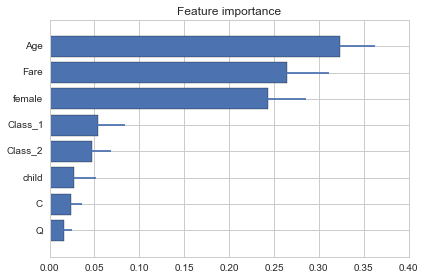

In [76]:
feat_labels = titanic_df.columns[1:]

all_x = titanic_df.iloc[:,1:]
all_t = titanic_df["Survived"]

forest = RandomForestClassifier(n_estimators=1000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(all_x, all_t)

# 特徴量の重要度の平均値
importances = forest.feature_importances_

# 各ツリーにおける特徴量から標準偏差を計算
std = np.std([tree.feature_importances_ for tree in forest.estimators_ ], axis=0)

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))


plt.figure()
plt.title('Feature importance')
plt.barh(range(importances.shape[0]), importances[indices][::-1], xerr = std[indices][::-1], align="center")
plt.yticks(range(importances.shape[0]), feat_labels[indices][::-1])
plt.tight_layout()
plt.show()

## グリッドサーチによるハイパーパラメータチューニング

In [88]:
from sklearn.grid_search import GridSearchCV

params = {'n_estimators' : [650, 700, 750, 800], 'max_depth':[6,8,10]}

rf_gs = RandomForestClassifier()

gs = GridSearchCV(estimator = rf_gs,
                  param_grid = params,
                 scoring = "accuracy",
                 cv = 10,
                 n_jobs = -1)

gs = gs.fit(all_x, all_t)

print("GridSearch_BestScore : {}".format(gs.best_score_))

print(gs.best_params_)



GridSearch_BestScore : 0.8282828282828283
{'max_depth': 10, 'n_estimators': 650}


In [78]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [101]:
from sklearn.grid_search import RandomizedSearchCV
import scipy as sp

params = {'n_estimators' : [650, 700, 750, 800], 'max_depth':sp.stats.randint(6,15)}

rs = RandomizedSearchCV(estimator = rf_gs,
                       param_distributions = params,
                        cv = 10,
                       n_iter=20,
                       scoring = 'accuracy',
                       n_jobs = -1)

rs.fit(X_train, y_train)

print("GridSearch_BestScore : {}".format(gs.best_score_))

print(gs.best_params_)

GridSearch_BestScore : 0.8282828282828283
{'max_depth': 10, 'n_estimators': 650}


In [91]:
np.random.randint(1,11)

2

In [103]:
print(__doc__)

import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   cv = 10,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf,
                           param_grid=param_grid,
                          cv = 10)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

Automatically created module for IPython interactive environment
RandomizedSearchCV took 13.41 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.947 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.938 (std: 0.027)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 10, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.932 (std: 0.028)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'bootstrap': True}



ValueError: min_samples_split must be at least 2 or in (0, 1], got 1